# Formula 1 - Predicting the winner of a race

In this notebook we will use getML to predict the winner of a Formula 1 race.

Summary:

- Prediction type: __Classification model__
- Domain: __Sports__
- Prediction target: __Win__ 
- Population size: __31578__

_Author: Dr. Patrick Urbanke_

# Background

We would like to develop a prediction model for Formula 1 races, that would allow us to predict the winner of a race before the race has started.

We use dataset of all Formula 1 races from 1950 to 2017. The dataset includes information such as the time taken in each lap, the time taken for pit stops, the performance in the qualifying rounds etc.

The dataset has been downloaded from the [CTU Prague relational learning repository](https://relational-data.org/dataset/ErgastF1) (Motl and Schulte, 2015).

# Analysis

Let's get started with the analysis and set up your session:

In [1]:
import copy
import os
from urllib import request

import numpy as np
import pandas as pd
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline  

import getml

getml.engine.launch()
getml.engine.set_project('formula1')

Launching ./getML --allow-push-notifications=true --allow-remote-ips=false --home-directory=/home/getml/.local/lib/python3.11/site-packages/getml --in-memory=true --install=false --launch-browser=true --log=false in /home/getml/.local/lib/python3.11/site-packages/getml/.getML/getml-1.4.0-x64-community-edition-linux...
Launched the getML engine. The log output will be stored in /home/getml/.getML/logs/20240318103758.log.
Loading pipelines... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

Connected to project 'formula1'


## 1. Loading data

### 1.1 Download from source

We begin by downloading the data:

In [2]:
conn = getml.database.connect_mariadb(
    host="db.relational-data.org",
    dbname="ErgastF1",
    port=3306,
    user="guest",
    password="relational"
)

conn

Connection(dbname='ErgastF1',
           dialect='mysql',
           host='db.relational-data.org',
           port=3306)

In [3]:
def load_if_needed(name):
    """
    Loads the data from the relational learning
    repository, if the data frame has not already
    been loaded.
    """
    if not getml.data.exists(name):
        data_frame = getml.data.DataFrame.from_db(
            name=name,
            table_name=name,
            conn=conn
        )
        data_frame.save()
    else:
        data_frame = getml.data.load_data_frame(name)
    return data_frame

In [4]:
driverStandings = load_if_needed("driverStandings")
drivers = load_if_needed("drivers")
lapTimes = load_if_needed("lapTimes")
pitStops = load_if_needed("pitStops")
races = load_if_needed("races")
qualifying = load_if_needed("qualifying")

In [5]:
driverStandings

name,driverStandingsId,raceId,driverId,points,position,wins,positionText
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,1,18,1,10,1,1,1
1,2,18,2,8,2,0,2
2,3,18,3,6,3,0,3
3,4,18,4,5,4,0,4
4,5,18,5,4,5,0,5
,...,...,...,...,...,...,...
31573,68456,982,835,8,16,0,16
31574,68457,982,154,26,13,0,13
31575,68458,982,836,5,18,0,18


In [6]:
drivers

name,driverId,number,driverRef,code,forename,surname,dob,nationality,url
role,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,44,hamilton,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lew...
1,2,nan,heidfeld,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nic...
2,3,6,rosberg,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nic...
3,4,14,alonso,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fer...
4,5,nan,kovalainen,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Hei...
,...,...,...,...,...,...,...,...,...
835,837,88,haryanto,HAR,Rio,Haryanto,1993-01-22,Indonesian,http://en.wikipedia.org/wiki/Rio...
836,838,2,vandoorne,VAN,Stoffel,Vandoorne,1992-03-26,Belgian,http://en.wikipedia.org/wiki/Sto...
837,839,31,ocon,OCO,Esteban,Ocon,1996-09-17,French,http://en.wikipedia.org/wiki/Est...


In [7]:
lapTimes

name,raceId,driverId,lap,position,milliseconds,time
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string
0,1,1,1,13,109088,1:49.088
1,1,1,2,12,93740,1:33.740
2,1,1,3,11,91600,1:31.600
3,1,1,4,10,91067,1:31.067
4,1,1,5,10,92129,1:32.129
,...,...,...,...,...,...
420364,982,840,54,8,107528,1:47.528
420365,982,840,55,8,107512,1:47.512
420366,982,840,56,8,108143,1:48.143


In [8]:
pitStops

name,raceId,driverId,stop,lap,milliseconds,time,duration
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,841,1,1,16,23227,17:28:24,23.227
1,841,1,2,36,23199,17:59:29,23.199
2,841,2,1,15,22994,17:27:41,22.994
3,841,2,2,30,25098,17:51:32,25.098
4,841,3,1,16,23716,17:29:00,23.716
,...,...,...,...,...,...,...
6065,982,839,6,38,29134,21:29:07,29.134
6066,982,840,1,1,37403,20:06:43,37.403
6067,982,840,2,2,29294,20:10:07,29.294


In [9]:
races

name,raceId,year,round,circuitId,name,date,time,url
role,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string,unused_string
0,1,2009,1,1,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/200...
1,2,2009,2,2,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/200...
2,3,2009,3,17,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/200...
3,4,2009,4,3,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/200...
4,5,2009,5,4,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/200...
,...,...,...,...,...,...,...,...
971,984,2017,16,22,Japanese Grand Prix,2017-10-08,05:00:00,https://en.wikipedia.org/wiki/20...
972,985,2017,17,69,United States Grand Prix,2017-10-22,19:00:00,https://en.wikipedia.org/wiki/20...
973,986,2017,18,32,Mexican Grand Prix,2017-10-29,19:00:00,https://en.wikipedia.org/wiki/20...


In [10]:
qualifying

name,qualifyId,raceId,driverId,constructorId,number,position,q1,q2,q3
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,1,18,1,1,22,1,1:26.572,1:25.187,1:26.714
1,2,18,9,2,4,2,1:26.103,1:25.315,1:26.869
2,3,18,5,1,23,3,1:25.664,1:25.452,1:27.079
3,4,18,13,6,2,4,1:25.994,1:25.691,1:27.178
4,5,18,2,2,3,5,1:25.960,1:25.518,1:27.236
,...,...,...,...,...,...,...,...,...
7392,7415,982,825,210,20,16,1:43.756,NULL,NULL
7393,7416,982,13,3,19,17,1:44.014,NULL,NULL
7394,7417,982,840,3,18,18,1:44.728,NULL,NULL


### 1.2 Prepare data for getML

In [11]:
racesPd = races.to_pandas()
racesPd

,raceId,year,round,circuitId,name,date,time,url
0,1.0,2009.0,1.0,1.0,Australian Grand Prix,2009-03-29,06:00:00,http://en.wikipedia.org/wiki/2009_Australian_G...
1,2.0,2009.0,2.0,2.0,Malaysian Grand Prix,2009-04-05,09:00:00,http://en.wikipedia.org/wiki/2009_Malaysian_Gr...
2,3.0,2009.0,3.0,17.0,Chinese Grand Prix,2009-04-19,07:00:00,http://en.wikipedia.org/wiki/2009_Chinese_Gran...
3,4.0,2009.0,4.0,3.0,Bahrain Grand Prix,2009-04-26,12:00:00,http://en.wikipedia.org/wiki/2009_Bahrain_Gran...
4,5.0,2009.0,5.0,4.0,Spanish Grand Prix,2009-05-10,12:00:00,http://en.wikipedia.org/wiki/2009_Spanish_Gran...
...,...,...,...,...,...,...,...,...
971,984.0,2017.0,16.0,22.0,Japanese Grand Prix,2017-10-08,05:00:00,https://en.wikipedia.org/wiki/2017_Japanese_Gr...
972,985.0,2017.0,17.0,69.0,United States Grand Prix,2017-10-22,19:00:00,https://en.wikipedia.org/wiki/2017_United_Stat...
973,986.0,2017.0,18.0,32.0,Mexican Grand Prix,2017-10-29,19:00:00,https://en.wikipedia.org/wiki/2017_Mexican_Gra...
974,987.0,2017.0,19.0,18.0,Brazilian Grand Prix,2017-11-12,16:00:00,https://en.wikipedia.org/wiki/2017_Brazilian_G...


We actually need some set-up, because the target variable is not readily available. The `wins` column in `driverStandings` is actually the accumulated number of wins over a year, but what we want is a boolean variable indicated whether someone has one a particular race or not.

In [12]:
driverStandingsPd = driverStandings.to_pandas()

driverStandingsPd = driverStandingsPd.merge(
    racesPd[["raceId", "year", "date", "round"]],
    on="raceId"
)

previousStanding = driverStandingsPd.merge(
    driverStandingsPd[["driverId", "year", "wins", "round"]],
    on=["driverId", "year"],
)

isPreviousRound = (previousStanding["round_x"] - previousStanding["round_y"] == 1.0)

previousStanding = previousStanding[isPreviousRound]

previousStanding["win"] = previousStanding["wins_x"] - previousStanding["wins_y"]

driverStandingsPd = driverStandingsPd.merge(
    previousStanding[["raceId", "driverId", "win"]],
    on=["raceId", "driverId"],
    how="left",
)

driverStandingsPd["win"] = [win if win == win else wins for win, wins in zip(driverStandingsPd["win"], driverStandingsPd["wins"])]

driver_standings = getml.data.DataFrame.from_pandas(driverStandingsPd, "driver_standings")

driver_standings

name,driverStandingsId,raceId,driverId,points,position,wins,year,round,win,positionText,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,1,18,1,10,1,1,2008,1,1,1,2008-03-16
1,2,18,2,8,2,0,2008,1,0,2,2008-03-16
2,3,18,3,6,3,0,2008,1,0,3,2008-03-16
3,4,18,4,5,4,0,2008,1,0,4,2008-03-16
4,5,18,5,4,5,0,2008,1,0,5,2008-03-16
,...,...,...,...,...,...,...,...,...,...,...
31573,68456,982,835,8,16,0,2017,14,0,16,2017-09-17
31574,68457,982,154,26,13,0,2017,14,0,13,2017-09-17
31575,68458,982,836,5,18,0,2017,14,0,18,2017-09-17


We also need to include the date of the race to `lapTimes` and `pitStops`, because we cannot use this data for the race we would like to predict. We can only take lap times and pit stops from previous races.

In [13]:
lapTimesPd = lapTimes.to_pandas()

lapTimesPd = lapTimesPd.merge(
    racesPd[["raceId", "date", "year"]],
    on="raceId"
)

lap_times = getml.data.DataFrame.from_pandas(lapTimesPd, "lap_times")

lap_times

name,raceId,driverId,lap,position,milliseconds,year,time,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string
0,1,1,1,13,109088,2009,1:49.088,2009-03-29
1,1,1,2,12,93740,2009,1:33.740,2009-03-29
2,1,1,3,11,91600,2009,1:31.600,2009-03-29
3,1,1,4,10,91067,2009,1:31.067,2009-03-29
4,1,1,5,10,92129,2009,1:32.129,2009-03-29
,...,...,...,...,...,...,...,...
420364,982,840,54,8,107528,2017,1:47.528,2017-09-17
420365,982,840,55,8,107512,2017,1:47.512,2017-09-17
420366,982,840,56,8,108143,2017,1:48.143,2017-09-17


In [14]:
pitStopsPd = pitStops.to_pandas()

pitStopsPd = pitStopsPd.merge(
    racesPd[["raceId", "date", "year"]],
    on="raceId"
)

pit_stops = getml.data.DataFrame.from_pandas(pitStopsPd, "pit_stops")

pit_stops

name,raceId,driverId,stop,lap,milliseconds,year,time,duration,date
role,unused_float,unused_float,unused_float,unused_float,unused_float,unused_float,unused_string,unused_string,unused_string
0,841,1,1,16,23227,2011,17:28:24,23.227,2011-03-27
1,841,1,2,36,23199,2011,17:59:29,23.199,2011-03-27
2,841,2,1,15,22994,2011,17:27:41,22.994,2011-03-27
3,841,2,2,30,25098,2011,17:51:32,25.098,2011-03-27
4,841,3,1,16,23716,2011,17:29:00,23.716,2011-03-27
,...,...,...,...,...,...,...,...,...
6065,982,839,6,38,29134,2017,21:29:07,29.134,2017-09-17
6066,982,840,1,1,37403,2017,20:06:43,37.403,2017-09-17
6067,982,840,2,2,29294,2017,20:10:07,29.294,2017-09-17


getML requires that we define *roles* for each of the columns.

In [15]:
driver_standings.set_role("win", getml.data.roles.target)
driver_standings.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
driver_standings.set_role("position", getml.data.roles.numerical)
driver_standings.set_role("date", getml.data.roles.time_stamp)

driver_standings

name,date,raceId,driverId,year,win,position,driverStandingsId,points,wins,round,positionText
role,time_stamp,join_key,join_key,join_key,target,numerical,unused_float,unused_float,unused_float,unused_float,unused_string
unit,"time stamp, comparison only",,,,,,,,,,
0,2008-03-16,18,1,2008,1,1,1,10,1,1,1
1,2008-03-16,18,2,2008,0,2,2,8,0,1,2
2,2008-03-16,18,3,2008,0,3,3,6,0,1,3
3,2008-03-16,18,4,2008,0,4,4,5,0,1,4
4,2008-03-16,18,5,2008,0,5,5,4,0,1,5
,...,...,...,...,...,...,...,...,...,...,...
31573,2017-09-17,982,835,2017,0,16,68456,8,0,14,16
31574,2017-09-17,982,154,2017,0,13,68457,26,0,14,13


In [16]:
drivers.set_role("driverId", getml.data.roles.join_key)
drivers.set_role(["nationality", "driverRef"], getml.data.roles.categorical)

drivers

name,driverId,nationality,driverRef,number,code,forename,surname,dob,url
role,join_key,categorical,categorical,unused_float,unused_string,unused_string,unused_string,unused_string,unused_string
0,1,British,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,http://en.wikipedia.org/wiki/Lew...
1,2,German,heidfeld,nan,HEI,Nick,Heidfeld,1977-05-10,http://en.wikipedia.org/wiki/Nic...
2,3,German,rosberg,6,ROS,Nico,Rosberg,1985-06-27,http://en.wikipedia.org/wiki/Nic...
3,4,Spanish,alonso,14,ALO,Fernando,Alonso,1981-07-29,http://en.wikipedia.org/wiki/Fer...
4,5,Finnish,kovalainen,nan,KOV,Heikki,Kovalainen,1981-10-19,http://en.wikipedia.org/wiki/Hei...
,...,...,...,...,...,...,...,...,...
835,837,Indonesian,haryanto,88,HAR,Rio,Haryanto,1993-01-22,http://en.wikipedia.org/wiki/Rio...
836,838,Belgian,vandoorne,2,VAN,Stoffel,Vandoorne,1992-03-26,http://en.wikipedia.org/wiki/Sto...
837,839,French,ocon,31,OCO,Esteban,Ocon,1996-09-17,http://en.wikipedia.org/wiki/Est...


In [17]:
lap_times.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
lap_times.set_role(["lap", "milliseconds", "position"], getml.data.roles.numerical)
lap_times.set_role("date", getml.data.roles.time_stamp)

lap_times

name,date,raceId,driverId,year,lap,milliseconds,position,time
role,time_stamp,join_key,join_key,join_key,numerical,numerical,numerical,unused_string
unit,"time stamp, comparison only",,,,,,,
0,2009-03-29,1,1,2009,1,109088,13,1:49.088
1,2009-03-29,1,1,2009,2,93740,12,1:33.740
2,2009-03-29,1,1,2009,3,91600,11,1:31.600
3,2009-03-29,1,1,2009,4,91067,10,1:31.067
4,2009-03-29,1,1,2009,5,92129,10,1:32.129
,...,...,...,...,...,...,...,...
420364,2017-09-17,982,840,2017,54,107528,8,1:47.528
420365,2017-09-17,982,840,2017,55,107512,8,1:47.512


In [18]:
pit_stops.set_role(["raceId", "driverId", "year"], getml.data.roles.join_key)
pit_stops.set_role(["lap", "milliseconds", "stop"], getml.data.roles.numerical)
pit_stops.set_role("date", getml.data.roles.time_stamp)

pit_stops

name,date,raceId,driverId,year,lap,milliseconds,stop,time,duration
role,time_stamp,join_key,join_key,join_key,numerical,numerical,numerical,unused_string,unused_string
unit,"time stamp, comparison only",,,,,,,,
0,2011-03-27,841,1,2011,16,23227,1,17:28:24,23.227
1,2011-03-27,841,1,2011,36,23199,2,17:59:29,23.199
2,2011-03-27,841,2,2011,15,22994,1,17:27:41,22.994
3,2011-03-27,841,2,2011,30,25098,2,17:51:32,25.098
4,2011-03-27,841,3,2011,16,23716,1,17:29:00,23.716
,...,...,...,...,...,...,...,...,...
6065,2017-09-17,982,839,2017,38,29134,6,21:29:07,29.134
6066,2017-09-17,982,840,2017,1,37403,1,20:06:43,37.403


In [19]:
qualifying.set_role(["raceId", "driverId", "qualifyId"], getml.data.roles.join_key)
qualifying.set_role(["position", "number"], getml.data.roles.numerical)

qualifying

name,raceId,driverId,qualifyId,position,number,constructorId,q1,q2,q3
role,join_key,join_key,join_key,numerical,numerical,unused_float,unused_string,unused_string,unused_string
0,18,1,1,1,22,1,1:26.572,1:25.187,1:26.714
1,18,9,2,2,4,2,1:26.103,1:25.315,1:26.869
2,18,5,3,3,23,1,1:25.664,1:25.452,1:27.079
3,18,13,4,4,2,6,1:25.994,1:25.691,1:27.178
4,18,2,5,5,3,2,1:25.960,1:25.518,1:27.236
,...,...,...,...,...,...,...,...,...
7392,982,825,7415,16,20,210,1:43.756,NULL,NULL
7393,982,13,7416,17,19,3,1:44.014,NULL,NULL
7394,982,840,7417,18,18,3,1:44.728,NULL,NULL


## 2. Predictive modeling

We loaded the data and defined the roles and units. Next, we create a getML pipeline for relational learning.

In [20]:
split = getml.data.split.random(train=0.8, test=0.2)
split

,
0,train
1,train
2,train
3,test
4,train
,...


### 2.1 Define relational model

In [21]:
star_schema = getml.data.StarSchema(population=driver_standings.drop(["position"]), alias="population", split=split)

star_schema.join(
    driver_standings,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
    lagged_targets=True,
)

# We cannot use lap times for the race
# we would like to predict, so we set
# a non-zero horizon.
star_schema.join(
    lap_times,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
)

# We cannot use pit stops for the race
# we would like to predict, so we set
# a non-zero horizon.
star_schema.join(
    pit_stops,
    on=["driverId"],
    time_stamps="date",
    horizon=getml.data.time.days(1),
)

star_schema.join(
    qualifying,
    on=["driverId", "raceId"],
    relationship=getml.data.relationship.many_to_one,
)

star_schema.join(
    drivers,
    on=["driverId"],
    relationship=getml.data.relationship.many_to_one,
)

star_schema

data model

  population:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - win: target
    - date: time_stamp
    - ...

    joins:
    - right: 'driver_standings'
      on: 
      - (population.driverId, driver_standings.driverId)
      time_stamps: (population.date, driver_standings.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: True
    - right: 'lap_times'
      on: 
      - (population.driverId, lap_times.driverId)
      time_stamps: (population.date, lap_times.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: False
    - right: 'pit_stops'
      on: 
      - (population.driverId, pit_stops.driverId)
      time_stamps: (population.date, pit_stops.date)
      relationship: 'many-to-many'
      horizon: 86400.0
      lagged_targets: False
    - right: 'qualifying'
      on: 
      - (population.driverId, qualifying.driverId)
      - (population.raceId, qualifying.raceId)
      relationship: 'many-to-one'
      lagged_targets: False
    - right: 'drivers'
      on: 
      - (population.driverId, drivers.driverId)
      relationship: 'many-to-one'
      lagged_targets: False

  driver_standings:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - position: numerical
    - win: target
    - ...

  lap_times:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - lap: numerical
    - milliseconds: numerical
    - ...

  pit_stops:
    columns:
    - raceId: join_key
    - driverId: join_key
    - year: join_key
    - lap: numerical
    - milliseconds: numerical
    - ...

  qualifying:
    columns:
    - raceId: join_key
    - driverId: join_key
    - qualifyId: join_key
    - position: numerical
    - number: numerical
    - ...

  drivers:
    columns:
    - nationality: categorical
    - driverRef: categorical
    - driverId: join_key
    - number: unused_float
    - code: unused_string
    - ...


container

  population
      subset   name                rows   type
  0   test     driver_standings    6229   View
  1   train    driver_standings   25349   View

  peripheral
      name                 rows   type     
  0   driver_standings    31578   DataFrame
  1   lap_times          420369   DataFrame
  2   pit_stops            6070   DataFrame
  3   qualifying           7397   DataFrame
  4   drivers               840   DataFrame

### 2.2 getML pipeline

<!-- #### 2.1.1  -->
__Set-up the feature learner & predictor__

We use the relboost algorithms for this problem. Because of the large number of keywords, we regularize the model a bit by requiring a minimum support for the keywords (`min_num_samples`).

In [22]:
fast_prop = getml.feature_learning.FastProp(
    loss_function=getml.feature_learning.loss_functions.CrossEntropyLoss,
    aggregation=getml.feature_learning.FastProp.agg_sets.All,
    num_threads=1,
)

predictor = getml.predictors.XGBoostClassifier(n_jobs=1)

__Build the pipeline__

In [23]:
pipe1 = getml.pipeline.Pipeline(
    tags=['fast_prop'],
    data_model=star_schema.data_model,
    feature_learners=[fast_prop],
    predictors=[predictor],
    include_categorical=True,
)

pipe1

Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=True,
         loss_function='CrossEntropyLoss',
         peripheral=['driver_standings', 'drivers', 'lap_times', 'pit_stops', 'qualifying'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['fast_prop'])

### 2.3 Model training

In [24]:
pipe1.check(star_schema.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Checking... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.


,type,label,message
0,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and LAP_TIMES__STAGING_TABLE_3 over 'driverId' and 'driverId', there are no corresponding entries for 68.551028% of entries in 'driverId' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."
1,INFO,FOREIGN KEYS NOT FOUND,"When joining POPULATION__STAGING_TABLE_1 and PIT_STOPS__STAGING_TABLE_4 over 'driverId' and 'driverId', there are no corresponding entries for 82.527910% of entries in 'driverId' in 'POPULATION__STAGING_TABLE_1'. You might want to double-check your join keys."


In [25]:
pipe1.fit(star_schema.train)

Checking data model...
Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          

The pipeline check generated 2 issues labeled INFO and 0 issues labeled WARNING.
To see the issues in full, run .check() on the pipeline.

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Trying 664 features... 100% |██████████| [elapsed: 01:23, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:19, remaining: 00:00]          
XGBoost: Training as predictor... 100% |██████████| [elapsed: 00:10, remaining: 00:00]          

Trained pipeline.
Time taken: 0h:1m:52.06394



Pipeline(data_model='population',
         feature_learners=['FastProp'],
         feature_selectors=[],
         include_categorical=True,
         loss_function='CrossEntropyLoss',
         peripheral=['driver_standings', 'drivers', 'lap_times', 'pit_stops', 'qualifying'],
         predictors=['XGBoostClassifier'],
         preprocessors=[],
         share_selected_features=0.5,
         tags=['fast_prop', 'container-ZGyibN'])

### 2.4 Model evaluation

In [26]:
pipe1.score(star_schema.test)

Staging... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
Preprocessing... 100% |██████████| [elapsed: 00:00, remaining: 00:00]          
FastProp: Building features... 100% |██████████| [elapsed: 00:05, remaining: 00:00]          



,date time,set used,target,accuracy,auc,cross entropy
0,2024-03-18 10:39:53,train,win,0.9714,0.9448,0.0825
1,2024-03-18 10:39:58,test,win,0.9714,0.9165,0.08801


### 2.5 Studying features

We take a look at the importance of the features FastProp has learned:

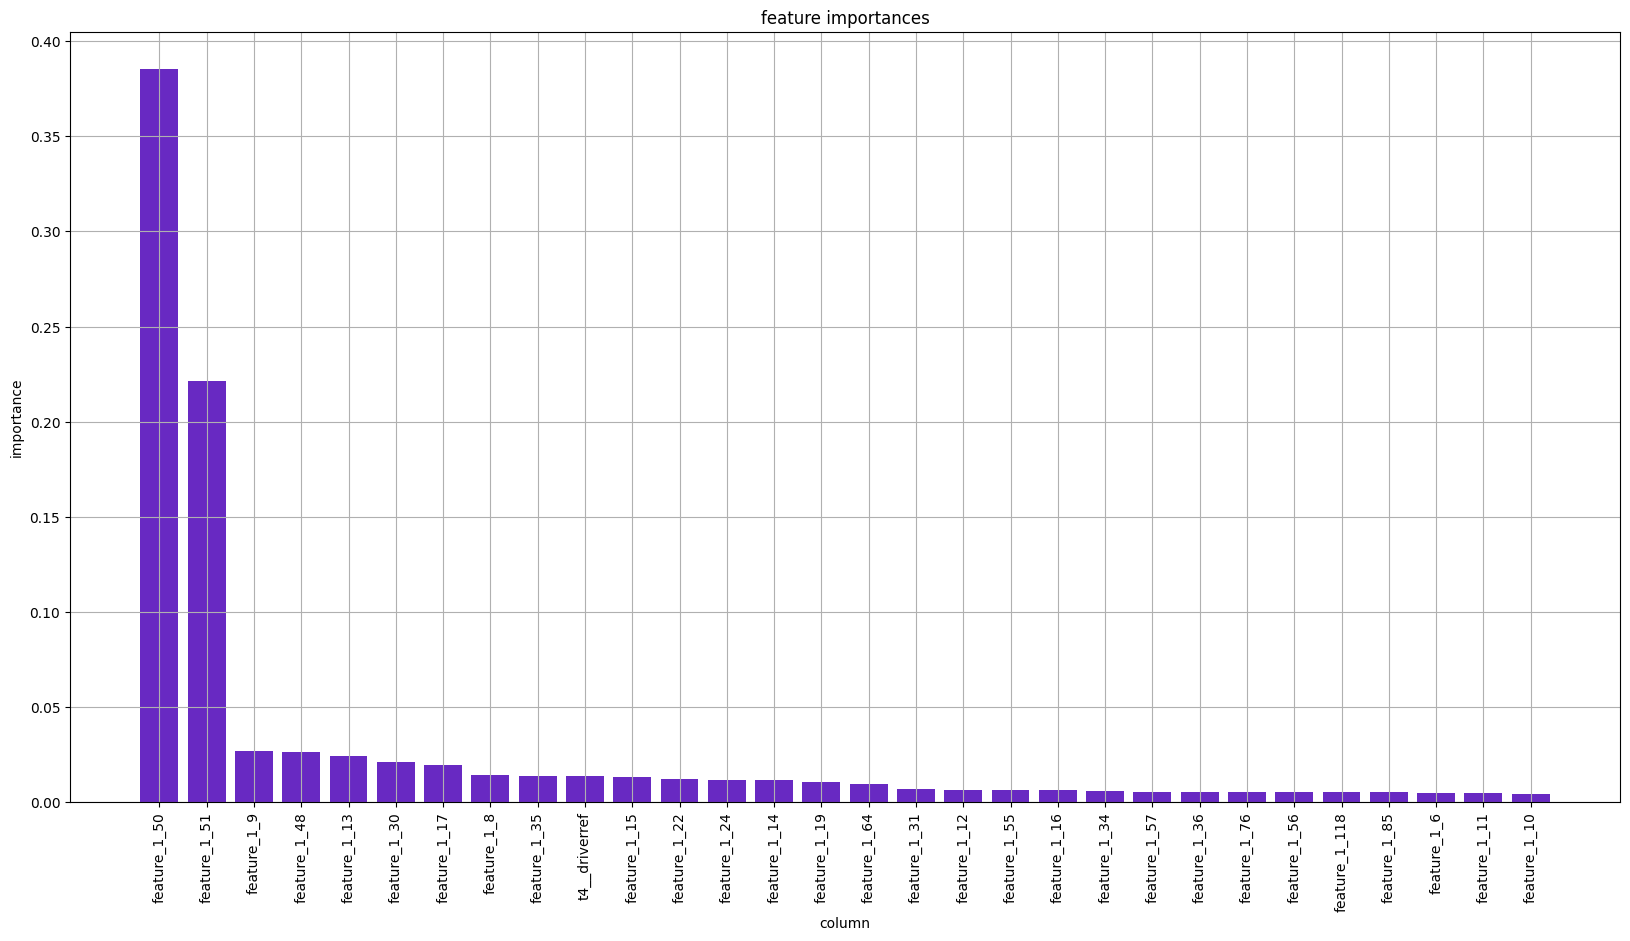

In [27]:
names, importances = pipe1.features.importances(target_num=0)

plt.subplots(figsize=(20, 10))

plt.bar(names[:30], importances[:30], color='#6829c2')

plt.title("feature importances")
plt.grid(True)
plt.xlabel("column")
plt.ylabel("importance")
plt.xticks(rotation='vertical')

plt.show()

We take a look at the most important features, to get an idea where the predictive power comes from:

In [28]:
pipe1.features.to_sql().find(names[0])[0]

```sql
DROP TABLE IF EXISTS "FEATURE_1_50";

CREATE TABLE "FEATURE_1_50" AS
SELECT EWMA_90D( t2."win" ORDER BY t1."date" - t2."date, '+1.000000 days'" ) AS "feature_1_50",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DRIVER_STANDINGS__STAGING_TABLE_2" t2
ON t1."driverid" = t2."driverid"
WHERE t2."date, '+1.000000 days'" <= t1."date"
GROUP BY t1.rowid;
```

In [29]:
pipe1.features.to_sql()[names[1]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_51";

CREATE TABLE "FEATURE_1_51" AS
SELECT EWMA_365D( t2."win" ORDER BY t1."date" - t2."date, '+1.000000 days'" ) AS "feature_1_51",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DRIVER_STANDINGS__STAGING_TABLE_2" t2
ON t1."driverid" = t2."driverid"
WHERE t2."date, '+1.000000 days'" <= t1."date"
GROUP BY t1.rowid;
```

In [30]:
pipe1.features.to_sql()[names[2]]

```sql
DROP TABLE IF EXISTS "FEATURE_1_9";

CREATE TABLE "FEATURE_1_9" AS
SELECT EWMA_7D( t2."position" ORDER BY t1."date" - t2."date, '+1.000000 days'" ) AS "feature_1_9",
       t1.rowid AS rownum
FROM "POPULATION__STAGING_TABLE_1" t1
INNER JOIN "DRIVER_STANDINGS__STAGING_TABLE_2" t2
ON t1."driverid" = t2."driverid"
WHERE t2."date, '+1.000000 days'" <= t1."date"
GROUP BY t1.rowid;
```

In [31]:
getml.engine.shutdown()

What we can learn from these features is the following: Knowing which driver we are talking about and who won the most recent races is the best predictor for whether a driver will win this race.

## 3. Conclusion

We have benchmarked getML against featuretools on dataset related to Formula 1 races. We have found that getML's FastProp outperforms featuretools.

## References

Motl, Jan, and Oliver Schulte. "The CTU prague relational learning repository." arXiv preprint arXiv:1511.03086 (2015).